In [3]:
# !pip install seaborn
# !pip install openpyxl
# !pip install ccxt
#!conda install -c conda-forge ta-lib -y
#!pip install TA-Lib
# !sudo pip uninstall tensorflow-gpu -y
# !sudo pip install tensorflow-gpu==2.6.5
#!conda install -c conda-forge ta-lib -y
# !pip install APScheduler

In [3]:
import os
import math
import numpy as np
import pandas as pd
import ccxt
import talib
from datetime import datetime
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from script.fetch_history_data import binance_fetch_history_price, binance_single_fetch_history_price
from script.preprocess import *
from script.transformer_timestep import *
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Tensorflow version: 2.6.5


In [4]:
batch_size = 32
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
valid_percent = 20
test_percent = 10

target_column='Close_MA_ptc_10'
pearson_corr_cutoff = 0.2
# ma_ptc_col_min = -0.04326610844852674
# ma_ptc_col_max = 0.03996161803797027

In [45]:
# df = binance_fetch_history_price(coin='BTC/USDT', timeframe='1h', start_date='2019-09-10')
# timeframes = [10,20,40,60,80,100,120,140,160,180,200]
# df_cal = calculate_technical_indicators(df, timeframes=timeframes)
# df_cal.to_pickle('./data/multi_factor_v2.0.1.pickle')

In [5]:

# zscore = (x - mean) / std
df_cal = pd.read_pickle('./data/multi_factor_v2.0.1.pickle')
df_cal_drop_col = df_cal.copy()
del df_cal_drop_col['Timestamp']
ma_ptc_col = [col for col in df_cal_drop_col.columns if 'MA_ptc' in col and 'Volume' not in col and col != 'Timestamp']
ma_ptc_col += ['ZhangDieFu', 'ZhenFu']	
zscore_std = df_cal_drop_col[ma_ptc_col].values.reshape(-1).std()
zscore_mean = df_cal_drop_col[ma_ptc_col].values.reshape(-1).mean()

for col in ma_ptc_col:
    df_cal_drop_col[col] = (df_cal_drop_col[col] - zscore_mean) / zscore_std

# pearson corr filter
filterd_col = [col for col in df_cal_drop_col.columns[(df_cal_drop_col.corr()[target_column].abs() >= pearson_corr_cutoff)]]
minmax_df = df_cal_drop_col[filterd_col]

In [6]:
print(zscore_std)
print(zscore_mean)

0.00267311022754158
0.0002555549748154441


In [15]:
df_train, df_val, df_test = preprocess_train_test_split(minmax_df, valid_percent=valid_percent, test_percent=test_percent)
X_train, y_train = preprocess_sequence_data(df_train, target_column=target_column, seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val, target_column=target_column, seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test, target_column=target_column, seq_len=seq_len)

In [16]:
X_train, y_train = preprocess_sequence_data(df_train, target_column=target_column, seq_len=seq_len)
X_val, y_val = preprocess_sequence_data(df_val, target_column=target_column, seq_len=seq_len)
X_test, y_test = preprocess_sequence_data(df_test, target_column=target_column, seq_len=seq_len)

In [17]:
feature_count = X_train.shape[2]
def create_model():
    '''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    '''Construct model'''
    in_seq = Input(shape=(seq_len, feature_count))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=in_seq, outputs=out)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001,
                                                                decay_steps=10000,
                                                                decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mape'])
    return model

model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./model_weight/transformer_btc_multi_factor_v2.0.1.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

2023-03-17 03:05:55.732957: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 03:05:56.606130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44773 MB memory:  -> device: 0, name: NVIDIA Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 94)]    0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 96)      0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 96)      1238848     concatenate[0][0]            

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))

Epoch 1/35
859/859 [==============================] - 607s 707ms/step - loss: 0.2817 - mae: 0.3451 - mape: 362.9697 - val_loss: 0.1229 - val_mae: 0.2450 - val_mape: 296.3220

Epoch 00001: val_loss improved from inf to 0.12287, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.1.hdf5
Epoch 2/35
859/859 [==============================] - 604s 703ms/step - loss: 0.2580 - mae: 0.3307 - mape: 411.5913 - val_loss: 0.1100 - val_mae: 0.2365 - val_mape: 293.2650

Epoch 00002: val_loss improved from 0.12287 to 0.11004, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.1.hdf5
Epoch 3/35
859/859 [==============================] - 602s 701ms/step - loss: 0.2462 - mae: 0.3236 - mape: 439.2758 - val_loss: 0.1057 - val_mae: 0.2289 - val_mape: 302.6723

Epoch 00003: val_loss improved from 0.11004 to 0.10566, saving model to ./model_weight/transformer_btc_multi_factor_v2.0.1.hdf5
Epoch 4/35
859/859 [==============================] - 603s 702ms/step - loss: 0.2286 - mae: 0.3

In [20]:
model = tf.keras.models.load_model('./model_weight/transformer_btc_multi_factor_v2.0.1.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred   = model.predict(X_val)
test_pred  = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval   = model.evaluate(X_val, y_val, verbose=0)
test_eval  = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}'.format(val_eval[0], val_eval[1]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}'.format(test_eval[0], test_eval[1]))

 
Evaluation metrics
Training Data - Loss: 0.0875, MAE: 0.1941
Validation Data - Loss: 0.0547, MAE: 0.1581
Test Data - Loss: 0.0484, MAE: 0.1389


In [21]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume,open_MA_10,High_MA_10,Low_MA_10,Close_MA_10,Volume_MA_10,open_MA_ptc_10,High_MA_ptc_10,Low_MA_ptc_10,Close_MA_ptc_10,Volume_MA_ptc_10,Bias,Cmo_10,Atr_10,Cci_10,Volume_pct,ZhangDieFu,ZhenFu,Rsi_10,Ic_10,Macd,Signal,Histogram,UpperBB_10,MiddleBB_10,LowerBB_10,SlowK,SlowD,UpperMAE_10,MiddleMAE_10,LowerMAE_10,OBV,open_MA_20,High_MA_20,Low_MA_20,Close_MA_20,Volume_MA_20,open_MA_ptc_20,High_MA_ptc_20,Low_MA_ptc_20,Close_MA_ptc_20,Volume_MA_ptc_20,Cmo_20,Atr_20,Cci_20,Rsi_20,Ic_20,UpperBB_20,MiddleBB_20,LowerBB_20,UpperMAE_20,MiddleMAE_20,LowerMAE_20,open_MA_40,High_MA_40,Low_MA_40,Close_MA_40,Volume_MA_40,open_MA_ptc_40,High_MA_ptc_40,Low_MA_ptc_40,Close_MA_ptc_40,Volume_MA_ptc_40,Cmo_40,Atr_40,Cci_40,Rsi_40,Ic_40,UpperBB_40,MiddleBB_40,LowerBB_40,UpperMAE_40,MiddleMAE_40,LowerMAE_40,open_MA_60,High_MA_60,Low_MA_60,Close_MA_60,Volume_MA_60,open_MA_ptc_60,High_MA_ptc_60,Low_MA_ptc_60,Close_MA_ptc_60,Volume_MA_ptc_60,Cmo_60,Atr_60,Cci_60,Rsi_60,Ic_60,UpperBB_60,MiddleBB_60,LowerBB_60,UpperMAE_60,MiddleMAE_60,LowerMAE_60,open_MA_80,High_MA_80,Low_MA_80,Close_MA_80,Volume_MA_80,open_MA_ptc_80,High_MA_ptc_80,Low_MA_ptc_80,Close_MA_ptc_80,Volume_MA_ptc_80,Cmo_80,Atr_80,Cci_80,Rsi_80,Ic_80,UpperBB_80,MiddleBB_80,LowerBB_80,UpperMAE_80,MiddleMAE_80,LowerMAE_80,open_MA_100,High_MA_100,Low_MA_100,Close_MA_100,Volume_MA_100,open_MA_ptc_100,High_MA_ptc_100,Low_MA_ptc_100,Close_MA_ptc_100,Volume_MA_ptc_100,Cmo_100,Atr_100,Cci_100,Rsi_100,Ic_100,UpperBB_100,MiddleBB_100,LowerBB_100,UpperMAE_100,MiddleMAE_100,LowerMAE_100,open_MA_120,High_MA_120,Low_MA_120,Close_MA_120,Volume_MA_120,open_MA_ptc_120,High_MA_ptc_120,Low_MA_ptc_120,Close_MA_ptc_120,Volume_MA_ptc_120,Cmo_120,Atr_120,Cci_120,Rsi_120,Ic_120,UpperBB_120,MiddleBB_120,LowerBB_120,UpperMAE_120,MiddleMAE_120,LowerMAE_120,open_MA_140,High_MA_140,Low_MA_140,Close_MA_140,Volume_MA_140,open_MA_ptc_140,High_MA_ptc_140,Low_MA_ptc_140,Close_MA_ptc_140,Volume_MA_ptc_140,Cmo_140,Atr_140,Cci_140,Rsi_140,Ic_140,UpperBB_140,MiddleBB_140,LowerBB_140,UpperMAE_140,MiddleMAE_140,LowerMAE_140,open_MA_160,High_MA_160,Low_MA_160,Close_MA_160,Volume_MA_160,open_MA_ptc_160,High_MA_ptc_160,Low_MA_ptc_160,Close_MA_ptc_160,Volume_MA_ptc_160,Cmo_160,Atr_160,Cci_160,Rsi_160,Ic_160,UpperBB_160,MiddleBB_160,LowerBB_160,UpperMAE_160,MiddleMAE_160,LowerMAE_160,open_MA_180,High_MA_180,Low_MA_180,Close_MA_180,Volume_MA_180,open_MA_ptc_180,High_MA_ptc_180,Low_MA_ptc_180,Close_MA_ptc_180,Volume_MA_ptc_180,Cmo_180,Atr_180,Cci_180,Rsi_180,Ic_180,UpperBB_180,MiddleBB_180,LowerBB_180,UpperMAE_180,MiddleMAE_180,LowerMAE_180,open_MA_200,High_MA_200,Low_MA_200,Close_MA_200,Volume_MA_200,open_MA_ptc_200,High_MA_ptc_200,Low_MA_ptc_200,Close_MA_ptc_200,Volume_MA_ptc_200,Cmo_200,Atr_200,Cci_200,Rsi_200,Ic_200,UpperBB_200,MiddleBB_200,LowerBB_200,UpperMAE_200,MiddleMAE_200,LowerMAE_200
30812,2023-03-13-07:00,22372.9,22488.4,22307.6,22451.6,32626.652,22112.68,22370.78,21998.44,22231.53,54332.5888,0.581233,0.584890,0.584782,0.584447,0.001466,4.649710,60.193910,294.610630,66.666667,0.246272,0.003522,0.008081,80.096955,0.015180,536.413239,459.313182,77.100057,22676.626484,22231.53,21786.433516,79.521584,72.622900,22676.626484,22231.53,21786.433516,-3042100.274,21361.425,21594.640,21260.450,21462.245,52435.3682,0.575166,0.575748,0.573807,0.576566,0.015028,52.126294,267.385816,66.666667,76.063147,0.034932,23115.818653,21462.245,19808.671347,23115.818653,21462.245,19808.671347,20840.1025,20995.8250,20766.0800,20900.0650,34864.159125,0.552673,0.553587,0.552901,0.554435,0.011292,34.250089,236.267620,66.666667,67.125044,0.056497,22527.053343,20900.0650,19273.076657,22527.053343,20900.0650,19273.076657,20612.936667,20753.171667,20530.648333,20653.536667,34454.645500,0.544524,0.543306,0.544008,0.543521,0.001687,23.336483,217.372856,66.666667,61.668242,0.064568,22168.274870,20653.536667,19138.798463,22168.274870,20653.536667,19138.798463,20448.44375,20582.98250,20349.55875,20474.72875,40010.198950,0.534887,0.535

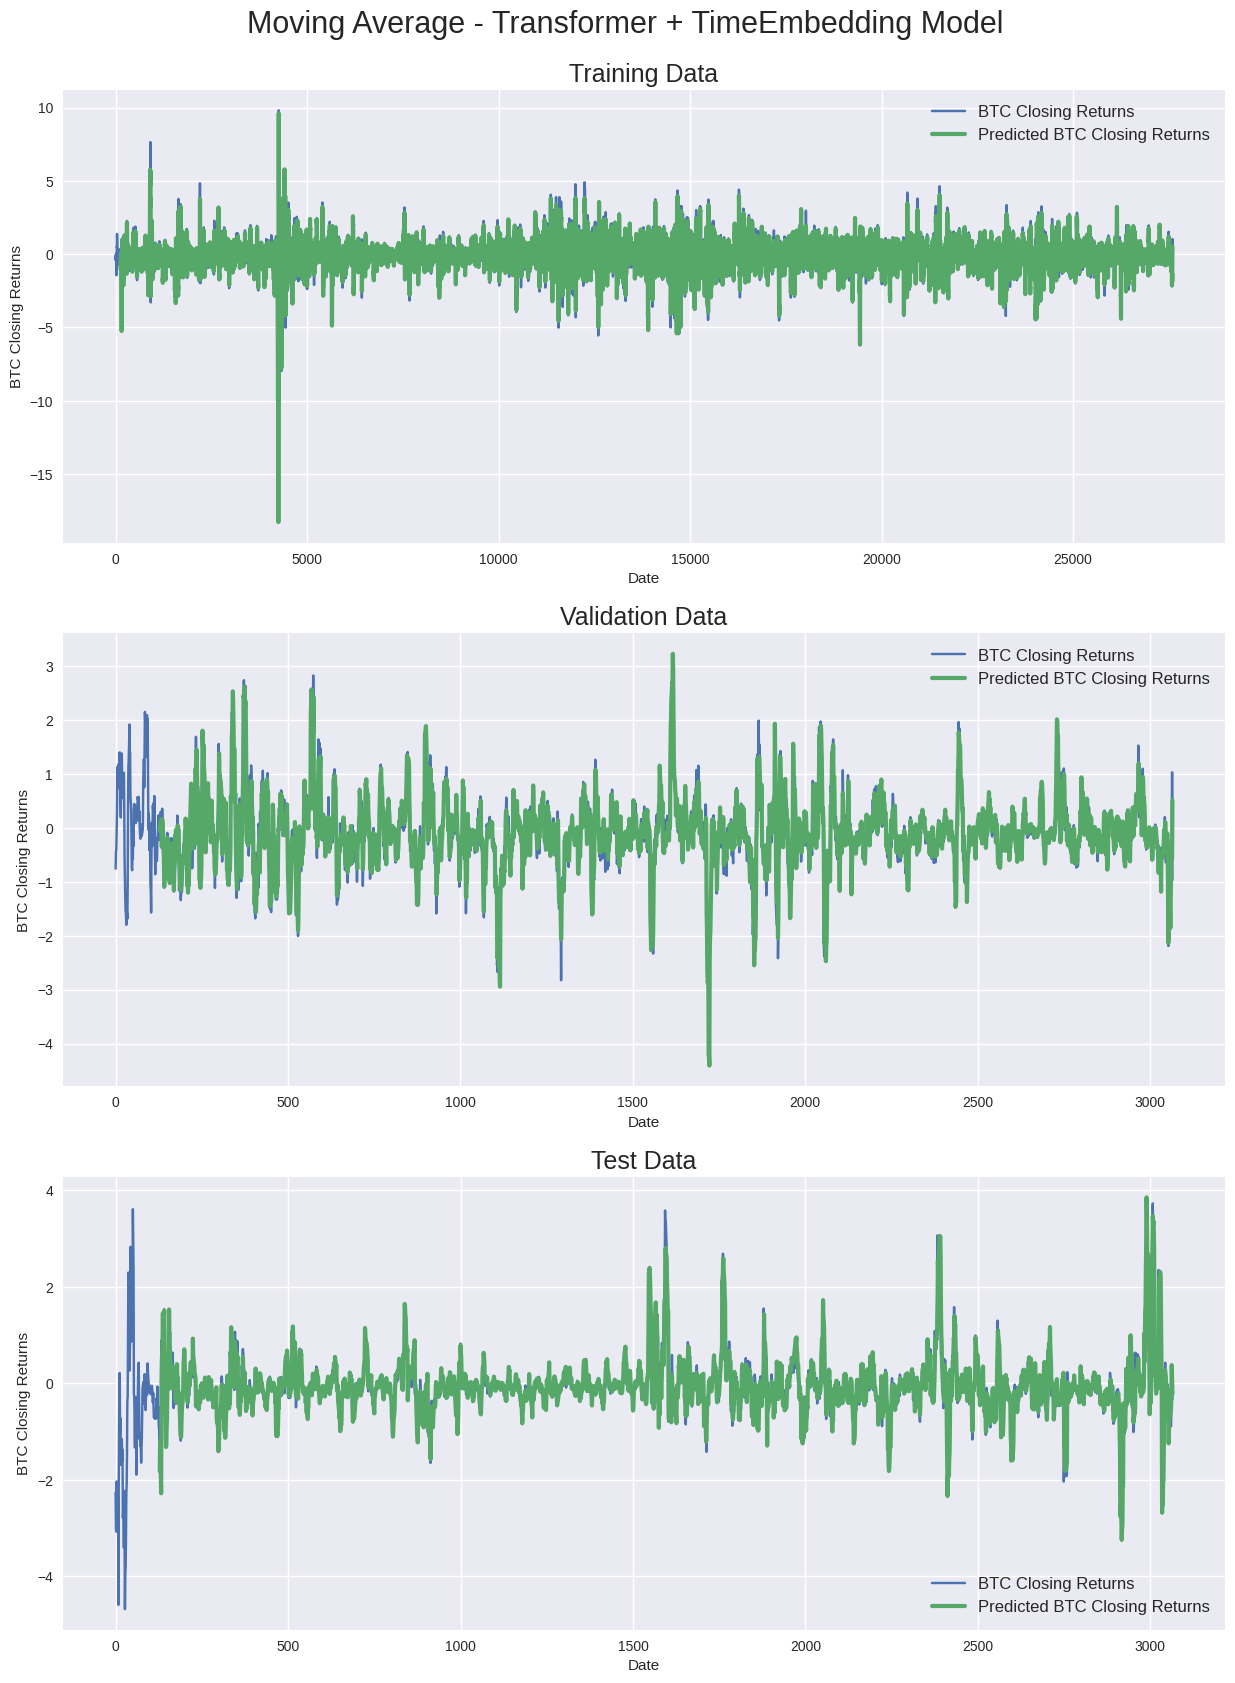

In [23]:

#'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(df_train.values[:, 3], label='BTC Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(df_val.values[:, 3], label='BTC Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(df_test.values[:, 3], label='BTC Closing Returns')
ax31.plot(np.arange(seq_len, test_pred[:].shape[0]+seq_len), test_pred[:], linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [24]:
#zscore = (x - mean) / std
def restore_zscore_close_price(df, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128):
    input_df = df.copy()
    # restore min mnax
    input_df[target_col][seq_len:] = input_df[target_col][seq_len:]*zscore_std + zscore_mean
    restored_close_list = []
    for idx in range(seq_len, len(input_df)):
        previois_avg     = input_df.loc[idx - moving_avg_step : idx - 1 ,'Close'].mean()
        close_avg        = previois_avg * (input_df[target_col][idx] + 1)
        restored_close   = (close_avg * moving_avg_step) - (input_df.loc[idx - (moving_avg_step -1) : idx - 1, 'Close'].sum())
        restored_close_list.append(restored_close)
    input_df['pred_Close'] = '-'
    input_df['pred_Close'][seq_len:] = restored_close_list
    return input_df

# def restore_zscore_close_price_v2(pred_df, all_col_df, target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128):
#     # copy close, close_MA_10, to pred_df
#     input_df = pred_df.copy()
#     input_df_all_columns = all_col_df.copy()
#     input_df['Close'] = input_df_all_columns['Close'][input_df.index]
#     input_df['Close_MA_10'] = input_df_all_columns['Close_MA_10'][input_df.index]
    
#     # restore min mnax
#     input_df = input_df.reset_index(drop=True)
#     input_df[target_col][seq_len:] = input_df[target_col][seq_len:]*zscore_std + zscore_mean
#     restored_close_list = []
#     for idx in range(seq_len, len(input_df)):
#         previois_avg     = input_df['Close_MA_10'][idx-1]
#         close_avg        = previois_avg * (input_df[target_col][idx] + 1)
#         restored_close   = (close_avg * moving_avg_step) - (input_df.loc[idx - (moving_avg_step -1) : idx - 1, 'Close'].sum())
#         restored_close_list.append(restored_close)
#     input_df['pred_Close'] = '-'
#     input_df['pred_Close'][seq_len:] = restored_close_list
#     return input_df

In [34]:
df_test['pred_Close_MA_ptc_10'] = '-'
df_test['pred_Close_MA_ptc_10'][seq_len:] = test_pred.flatten()

In [35]:
df = pd.read_pickle('./data/multi_factor_v2.0.1.pickle')
df_test['Close'] = df['Close'][df_test.index]
df_test['Close_MA_10'] = df['Close_MA_10'][df_test.index]
df_test = restore_zscore_close_price(df_test.reset_index(drop=True), target_col='pred_Close_MA_ptc_10', moving_avg_step=10, seq_len=128)
df_test.to_pickle('./output_file/20230317_multi_factor_v2.0.1.pickle')

In [37]:
df_test[['Close','pred_Close']]

,Close,pred_Close
0,18584.5,-
1,18238.0,-
2,18135.8,-
3,18691.7,-
4,18448.6,-
...,...,...
3060,24206.2,24444.211932
3061,24328.4,24370.147832
3062,24365.6,24426.427798
3063,24271.9,24386.834103


In [42]:
df['Close'].tail(10)

30807    22174.5
30808    22221.7
30809    22309.1
30810    22387.4
30811    22372.8
30812    22451.6
30813    22185.3
30814    21956.0
30815    22113.0
30816    22031.1
Name: Close, dtype: float64

In [7]:
df_test

NameError: name 'df_test' is not defined